<a href="https://colab.research.google.com/github/pedroAndrad1/linguagem_natural/blob/master/linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vamos tratar agora de linguagem natural, usando um dataset de resenhas do imdb. Usaremos este dataset para construir um modelo capaz de saber se um texto é um comentário negativo ou positivo.

Link para o data set: https://www.kaggle.com/luisfredgs/imdb-ptbr

In [2]:
#Antes de tudo, preciso fazer o download do csv que esta salvo em meu drive.
#Esse codigo esta em code snippet, na opcao insert.


# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1Ljf5FQqzeFM1SVmjdcOlFzlaO05IBe6l'
downloaded= drive.CreateFile({'id': file_id})
downloaded.GetContentFile('imdb-reviews-pt-br.csv') #Essa linha nao esta no snippet, aqui e pra de fato pegar o csv.


     |████████████████████████████████| 993kB 2.8MB/s 


In [3]:
#Lendo o csv com o pandas
import pandas as pd

dataframe = pd.read_csv('imdb-reviews-pt-br.csv')

dataframe.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [0]:
#Vou pegar a coluna de sentiment e a partir dela criar uma nova coluna com 0 para neg e 1 para pos.
classificacao = dataframe["sentiment"].replace(['neg','pos'] , ['0', '1'])

#Agora vou adicionar essa coluna no dataframe com o mesmo nome
dataframe['classificacao'] = classificacao



#Bag of words

Antes de criarmos um modelo a partir do dataset, temos que nos atentar que as nossas features não são números e sim texto. A máquina não vai reconhecer essas features. Temos que criar uma representação para o texto, a chamada bag of words. Assim poderemos passar esta para o modelo aprender.

link para saber mais da bag_of_words: https://machinelearningmastery.com/gentle-introduction-bag-words-model/

Para criar a matriz esparsa, usararei o CountVectorizer do modulo feature_extraction.text da biblioteca sklearn. Também usaremos o CountVectorizer pra conseguir nosso vocabulario.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

#Vou passar dois paramatros para criar o CountVectorizer:
#O primeiro e o lowercase = false, para as letras maiusculas nao serem covertidas para minusculas
#e o segundo e o max_features = 50. Se eu nao passo nenhum max_features, o countVectorizer fara
#um vetor de n dimensoes, tal que n e igual ao numero de palavras diferentes. Mas isso seria muito caro,
#pois o vetor teria milhares de dimensoes. Passando max_features = 50, delimito que o vetor tera as 50
#palavras mais frequentes do meu corpus.

#Estou vetorizando antes de dividir entre teste e treino para nao correr o risco de uma palavra do teste
#nao estar no vocabulario do treino. Soube que isso tem desvantagens, mas ainda nao sei quais sao.

vetorizador = CountVectorizer(lowercase = False, max_features= 50)

bag_of_words = vetorizador.fit_transform(dataframe.text_pt, dataframe.classificacao)
vocabulario = vetorizador.get_feature_names()

Para transfomar nosso bag_of_words em um dataframe do pandas, não podemos simplesmente passa-lo como paramâtro para o DataFrame. O DataFrame não lida bem com matriz esparsa. Então, iremos usar uma estrutura que lide bem, o SparseDataFrame * *anjos cantando ao fundo* *.

In [6]:
bag_dataframe = pd.SparseDataFrame(bag_of_words, columns = vocabulario)

bag_dataframe

,Eu,ao,apenas,as,com,como,da,de,do,dos,ela,ele,eles,em,era,esse,este,está,eu,filme,filmes,foi,história,isso,mais,mas,me,muito,na,no,não,os,ou,para,por,quando,que,realmente,se,ser,seu,sobre,sua,são,também,tem,tão,um,uma,você
0,NaN,1.0,NaN,NaN,2.0,1.0,NaN,4,4.0,2.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,4.0,NaN,3.0,4.0,1.0,1.0,1.0,2.0,2.0,7,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,3,2.0,NaN
1,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7,1.0,2.0,NaN,1.0,NaN,3.0,1.0,2.0,2.0,NaN,2.0,4.0,3.0,1.0,NaN,1.0,NaN,2.0,1.0,NaN,1.0,1.0,2.0,3.0,3.0,2.0,1.0,NaN,10,1.0,2.0,NaN,1.0,NaN,NaN,2.0,NaN,1.0,NaN,4,2.0,1.0
2,1.0,NaN,NaN,NaN,3.0,1.0,NaN,10,2.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,2.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,3.0,4.0,1.0,NaN,1.0,2.0,1.0,8,NaN,1.0,NaN,NaN,NaN,NaN,3.0,1.0,NaN,1.0,3,2.0,2.0
3,2.0,NaN,1.0,4.0,7.0,2.0,1.0,13,3.0,1.0,NaN,1.0,2.0,6.0,1.0,1.0,2.0,NaN,8.0,4.0,2.0,1.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,3.0,NaN,4.0,1.0,2.0,7,NaN,3.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,7,4.0,1.0
4,NaN,NaN,1.0,2.0,3.0,NaN,1.0,16,2.0,1.0,1.0,NaN,2.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,2.0,NaN,2.0,1.0,1.0,5.0,NaN,NaN,4,2.0,1.0,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3,4.0,NaN
5,NaN,1.0,NaN,NaN,1.0,1.0,NaN,3,NaN,1.0,NaN,2.0,NaN,2.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2,NaN,NaN
6,1.0,NaN,1.0,NaN,1.0,1.0,NaN,10,NaN,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,3.0,1.0,2.0,NaN,2.0,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,6,NaN,1.0,2.0,2.0,NaN,NaN,1.0,1.0,2.0,NaN,5,NaN,NaN
7,1.0,NaN,NaN,NaN,1.0,2.0,NaN,6,3.0,NaN,NaN,NaN,1.0,NaN,NaN,3.0,1.0,NaN,2.0,5.0,1.0,NaN,2.0,2.0,3.0,NaN,NaN,2.0,NaN,1.0,5.0,1.0,NaN,1.0,NaN,NaN,6,1.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,3,2.0,4.0
8,NaN,NaN,1.0,NaN,1.0,1.0,NaN,10,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,1.0,1.0,NaN,3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2.0,1.0
9,NaN,NaN,NaN,NaN,3.0,2.0,3.0,15,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,NaN,1.0,3.0,2.0,1.0,1.0,NaN,NaN,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,4,3.0,NaN


#Fazendo a regressão com o LogisticRegression

Agora vamos finalmente splitar nossos dados e fazer uma regressão usando o LogisticRegression do modulo linear_model do sklearn.

In [7]:
from sklearn.model_selection import train_test_split
#Vou colocar essa logica de criar o bag of words, o modelo e testar a acuraracia em uma funcao, para usar mais tarde.

x_treino, x_teste, y_treino, y_teste = train_test_split(bag_of_words, dataframe.classificacao, stratify = dataframe.classificacao)

from sklearn.linear_model import LogisticRegression

estimador = LogisticRegression(random_state = 0, solver = 'lbfgs') 
#Só estou passando um solver pq senao da um aviso dizendo que o lbfgs sera o solver padrao no futuro.
estimador.fit(x_treino, y_treino)

acuracia = estimador.score(x_teste, y_teste)
acuracia

0.644237767893247

Vou colocar essa logica de criar o bag of words, o modelo, splitar e testar a acuraracia em uma funcao, para usar mais tarde.



In [0]:
def classificar_texto(dataframe, coluna_interesse, coluna_classificacao):
  vetorizador = CountVectorizer(lowercase = False, max_features= 50)

  bag_of_words = vetorizador.fit_transform(dataframe[coluna_interesse], dataframe[coluna_classificacao])
  vocabulario = vetorizador.get_feature_names()
  
  bag_dataframe = pd.SparseDataFrame(bag_of_words, columns = vocabulario)
  
  x_treino, x_teste, y_treino, y_teste = train_test_split(bag_of_words, dataframe.classificacao, stratify = dataframe.classificacao)
  
  estimador = LogisticRegression(random_state = 0, solver = 'lbfgs') 
  #Só estou passando um solver pq senao da um aviso dizendo que o lbfgs sera o solver padrao no futuro.
  estimador.fit(x_treino, y_treino)

  acuracia = estimador.score(x_teste, y_teste)
  
  print(acuracia)
  

#Entendendo melhor o corpus textual (Nossas frases) com o word cloud

Para melhorar nossa acurácia, precisamos entender mais do corpus textual. Podemos usar uma word cloud para ver quais são as palavras mais frequentes em nosso corpus. 

Existe uma classe para criar uma word cloud, chamada, pasmem, WordCloud. Esta classe esta na biblioteca wordcloud, tudo muito surpreedente.

Link interessante:
https://github.com/amueller/word_cloud

documentação:
http://amueller.github.io/word_cloud/

compressão de lista:
https://blog.alura.com.br/simplicando-o-processamento-com-compreensao-de-lista-do-python/

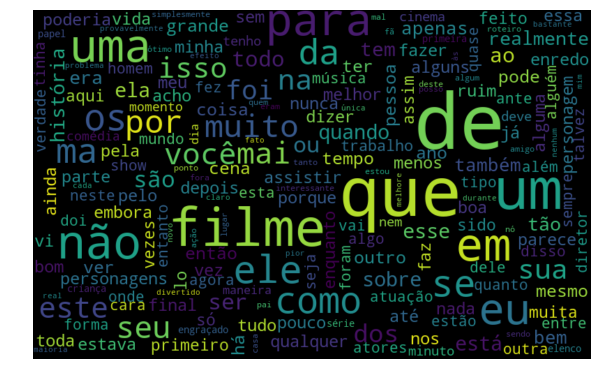

In [9]:
from wordcloud import WordCloud

#Vou passar alguns parametros na instanciacao da WordCloud:
#width e height para dizer qual sera o espaco de distribuicao das palavras no canvas.
#Repare que nao e o tamanho da imagem, ate porque esta sera plotada com o matplotlib;
#O max_font_size e para impedir que as palavras crescam demais, embora sua frequencia peça isso.
#Assim, facilitando a visualizacao;
#Por fim, vou colocar o collocations = False. Para as palavram serem analisadas individualmente e nao em pares.
#Exemplo, em vez de analisar a frequencia de "um filme", sera analisado a frequencia de "um" e de "filme"

word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False)#Estes valores estao na maioria dos exemplos no github.

#Agora que ja temos objeto WordCloud, podemos usar o metodo generate() para obter as informacoes para plotarmos a imagem.
#Este metodo recebe uma variavel com todo o texto e retorna as informacoes para plotar a imagem.
#entao temos que converter a nossa lista com cada frase em uma unica variavel.
#O metodo join resolve essa situacao. Tem um link para saber mais sobre esse metodo de compressão de lista no texto acima.

#Vou colocar um espaco como separador na nossa string.
corpus_comprimido = ' '.join(texto for texto in dataframe.text_pt) 

plot_info = word_cloud.generate(corpus_comprimido)

#Temos tudo o que e preciso para o matplotlib plotar a imagem da word cloud.

import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
#O paramatro interpolation e para melhorar a nitidez da imagem.
plt.imshow(plot_info, interpolation = 'bilinear')
#Vou colocar o axis como off para nao aparecer os valores do eixos da imagem.
#Estes seriam a altura e a largura.
plt.axis("off")
plt.show()



Essa imagem tem palavas de features negativas e positivas. E interessante ter uma word cloud para cada classe. Para segregar as features, o pandas tem um metodo chamado query, que retorna um dataframe. Este metodo recebe um parametro para quais features nos queremos. Nesse caso, queremos todas as linhas em que a coluna sentiment e igual a pos ou neg, entao o fica:
dataframe.query("coluna == 'classe' ").

In [0]:
#Pra facilitar o futuro, vou criar duas funcoes. Uma que plota uma word cloud para sentimentos positivos e outra para negativos.

def word_cloud_positivo(dataframe):
  features_pos = dataframe.query("sentiment == 'pos' ")
  #Agora e so repetir o processo de instanciar um WordCloud, usar o metodo generate e plotar a imagem com o matplotlib.
  
  word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False)
  
  #So que ao inves de pegar todos os textos do dataframe, vamos usar os da classe segregadada.
  texto_comprimido = ' '.join(texto for texto in features_pos.text_pt) 
  plot_info = word_cloud.generate(texto_comprimido)
  
  plt.figure(figsize = (10,7))
  #O paramatro interpolation e para melhorar a nitidez da imagem.
  plt.imshow(plot_info, interpolation = 'bilinear')
  #Vou colocar o axis como off para nao aparecer os valores do eixos da imagem.
  #Estes seriam a altura e a largura.
  plt.axis("off")
  plt.show()
  
  
def word_cloud_negativo(dataframe):
  features_neg = dataframe.query("sentiment == 'neg' ")
  #Agora e so repetir o processo de instanciar um WordCloud, usar o metodo generate e plotar a imagem com o matplotlib.
  
  word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False)
  
  #So que ao inves de pegar todos os textos do dataframe, vamos usar os da classe segregadada.
  texto_comprimido = ' '.join(texto for texto in features_neg.text_pt) 
  plot_info = word_cloud.generate(texto_comprimido)
  
  plt.figure(figsize = (10,7))
  #O paramatro interpolation e para melhorar a nitidez da imagem.
  plt.imshow(plot_info, interpolation = 'bilinear')
  #Vou colocar o axis como off para nao aparecer os valores do eixos da imagem.
  #Estes seriam a altura e a largura.
  plt.axis("off")
  plt.show()

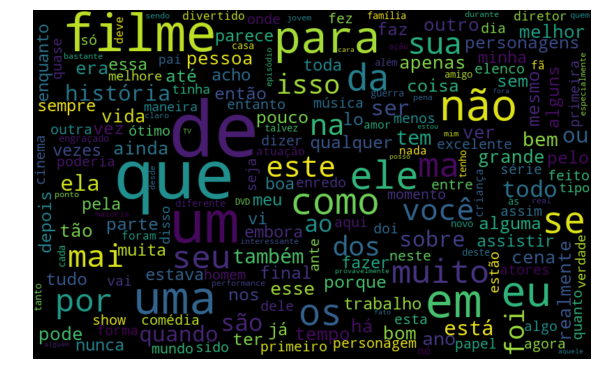

In [11]:
word_cloud_positivo(dataframe)

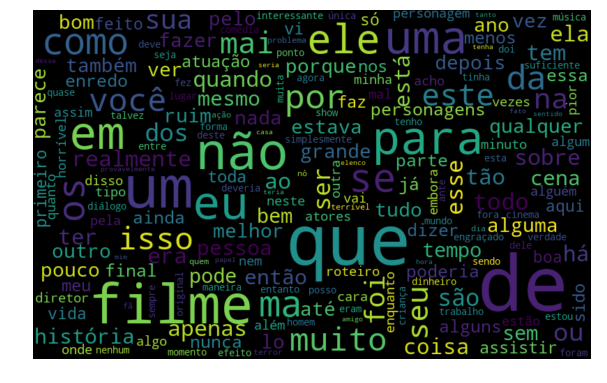

In [12]:
word_cloud_negativo(dataframe)

#Tokenização, separando por espaços em branco.

Vamos dizer que eu queira saber quais são as 10 palavras mais frequentes em meu corpus textual, o word cloud não parece ser muito bom para essa função.

Então, vamos separar cada palavra em uma lista e calcular sua frequência. Para isso, vamos usar 
a biblioteca NLTK. Mais especificamente, a classe tokenize.

In [13]:
from nltk import tokenize

#Primeiro, vamos precisar aglutinar todas features do nosso dataset em uma unica variavel.
#Por sorte, ja fizemos isso comprimindo a lista com o join() e salvamos na variavel texto_comprimido.

#Vamos tokenizar nosso texto, separando cada token por um espaco em branco. Que e como as palavras estao separadas.
tokenizador = tokenize.WhitespaceTokenizer()

tokens = tokenizador.tokenize(corpus_comprimido)

#Vamos ver a frequencia de cada palavra.
import nltk
frequencia = nltk.FreqDist(tokens) #A funcao FreqDist retorna um dicionario onde as palavras sao chaves e as frequencias sao os valores.
frequencia


FreqDist({'Mais': 1538,
          'uma': 130888,
          'vez,': 1927,
          'o': 244881,
          'Sr.': 1741,
          'Costner': 50,
          'arrumou': 3,
          'um': 216410,
          'filme': 117543,
          'por': 61339,
          'muito': 51761,
          'mais': 53504,
          'tempo': 10424,
          'do': 101737,
          'que': 325070,
          'necessário.': 135,
          'Além': 3631,
          'das': 16496,
          'terríveis': 576,
          'seqüências': 586,
          'de': 417651,
          'resgate': 152,
          'no': 57145,
          'mar,': 63,
          'quais': 1537,
          'há': 15824,
          'poucas,': 7,
          'eu': 68814,
          'simplesmente': 6436,
          'não': 127915,
          'me': 19136,
          'importei': 109,
          'com': 99174,
          'nenhum': 4531,
          'dos': 41222,
          'personagens.': 1027,
          'A': 31547,
          'maioria': 5565,
          'nós': 3944,
          'tem': 2498

Para visualizar melhor, vamos usar o pandas para montar um DataFrame com o dicionario de frequencias retornado pela funcao FreqDist

In [14]:
#Vou passar como parametro um dicionario com cada nome de coluna e uma lista com os valores.
#A coluna das palavras serao as chaves do dicionario que recebemos anteriormente
#e a coluna das frequencias serao as chaves deste.

dicionario = {"palavra" : list(frequencia.keys()),
              "frequencias" : list(frequencia.values())}
frequencias_df = pd.DataFrame(dicionario)

#Agora podemos ver quais sao as 10 maiores frequencias com a funcao nlargest() do pandas.
#Esta me devolve um dataframe ordenado com os n maiores features baseado na coluna que eu decidir.

frequencias_df.nlargest(columns = "frequencias", n = 10)

,palavra,frequencias
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


Vamos plotar agora estas n mais frequentes palavras em um gráfico de barras usando a biblioteca seaborn.

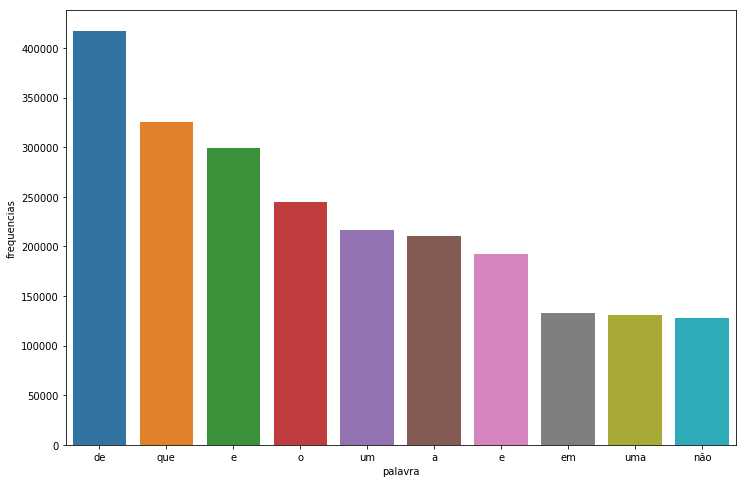

In [15]:
import seaborn as sns

#Vou aproveitar e colocar todo o processo de tokenizar as features do dataset e plotar as n maiores frequencias em uma funcao.
#Esta funcao recebera como parametro o dataframe, a coluna de interesse, no caso text_pt, e a quantidade de palavras para plotar.
#Um grafico de barras e tambem chamado de pareto.

def pareto(dataframe, coluna_interesse, quantidade):
  #Comprimindo o corpus textual
  corpus_comprimido = ' '.join(texto for texto in dataframe[coluna_interesse]) 
  
  #Tokenizando e calculando as frequencias
  tokenizador = tokenize.WhitespaceTokenizer()
  tokens = tokenizador.tokenize(corpus_comprimido)
  frequencia = nltk.FreqDist(tokens)
  
  #Criando o dataframe
  dicionario = {"palavra" : list(frequencia.keys()),
              "frequencias" : list(frequencia.values())}
  frequencias_df = pd.DataFrame(dicionario)
 
  #plotando o grafico de barras, vulgo pareto, com os n features mais frequentes.
  
  frequencias_df_nmais = frequencias_df.nlargest(columns = "frequencias", n = quantidade)
  plt.figure( figsize = (12,8) )
  sns.barplot(data = frequencias_df_nmais, x = "palavra", y = "frequencias")
  
pareto(dataframe, "text_pt", 10)

#Tratamento dos dados

Vamos escovar nossas features para melhorar a acurácia de nosso modelo.

#0 Stop words

Palavras como "de", "que", "e" aparecem muitos em nossas features. Porém, estas palavras não tem relevâncias para a classificação de sentimentos. E pior, estão ofuscando as que tem, como visto no gráfico de pareto, onde a palavra "filme" não está nem entre os top 10 de frequências.

Estas palavras sem relevância são chamadas de stop words e até existe uma lista delas em português na biblioteca nltk. Vamos usar essa lista para tirar todas as stop words de nossas features.

In [16]:
#Primeiro vamos pegar a lista de stop words em portugues do nltk
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words("portuguese")

#Agora vamos fazer um script para pegar cada feature, tirar as stopwords e 
#colocar essa feature tratada em uma nova coluna que chamarei de tratamento_0.
#Faremos isso tokenizando uma por uma, tirando as stop words e depois juntando
#tudo de novo com o join().

frases_processadas = list()#Aqui ficaram nossas features tratadas
tokenizador = tokenize.WhitespaceTokenizer()

#Para cada feature da coluna text_pt do dataframe
for feature in dataframe.text_pt:
  #Aqui ficaram os tokens de nossa palavras, sem os tokens stop words.
  nova_frase = list() 
  #dividindo a feature em tokens.
  palavra_texto = tokenizador.tokenize(feature)
 
  #Agora vamos iterar na lista de tokens para tirar as stop words.
  #Para cada item na lista palavra_texto, os tokens.
  for palavra in palavra_texto:
    #Se a palavra nao estiver na lista de stopwords, entao posso adicioanar
    #na lista nova_frase.
      if(palavra not in stop_words):
          nova_frase.append(palavra)
  #Vou juntar a lista nova_frase em uma string com o join(), separando por espaco,
  #e adicionar na lista de frases processadas.
  frases_processadas.append( ' '.join(nova_frase) )
  

#Feito isso tudo, vou criar a coluna tratamento_0 e colocar todas as frases tratadas la.
dataframe["tratamento_0"] = frases_processadas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
dataframe.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_0
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


Vamos ver agora como fica o gráfico de pareto.

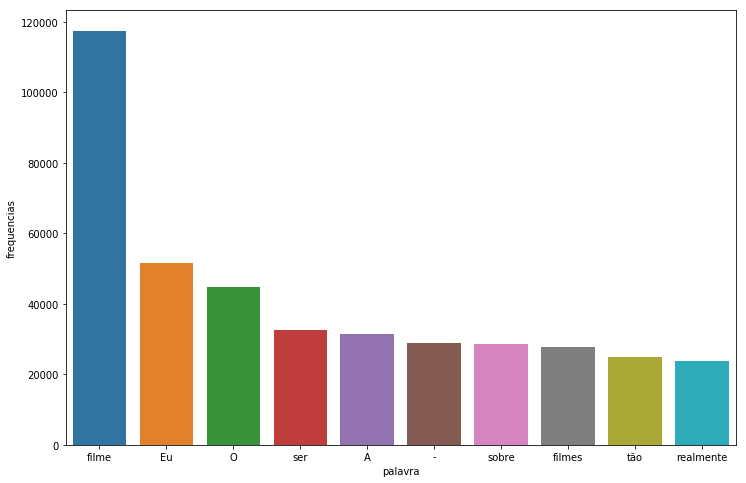

In [18]:
pareto(dataframe, "tratamento_0", 10)

Vamos ver também se a acurácia melhorou depois desse primeiro tratamento.

In [19]:
classificar_texto(dataframe, "tratamento_0", "classificacao")

#Melhorou em quase 2%. Não é muito, mas já é uma melhora.

0.6665588354225637


#1 Tokenização, retirando a pontuação das features

Quando separamos as features em tokens anteriormente, usamos o WhitespaceTokenizer. Este sepera cada token por espaço. Por exemplo, a frase "Muito bom o filme!" ficaria ["Muito" , "bom", "o" ,   "filme!"]. Perceba que a acentuação depois de "filme" não foi separada em um token. Isso pode causar problemas na hora de representarmos a frequência, pois "filme!" e "filme" deveriam representar a mesma coisa. Isso faz tanta diferença, que o CountVectorizer já tira a pontuação automáticamente na hora de criar o bag of words.

Então, vamos usar outra classe para Tokenizar nossas features. A classe WordPunctTokenizer.
Faremos a retirada dos pontos do mesmo jeito que retiramos as stop words, mas usando uma lista contendo todos os pontos dessa vez. 

A lista está na biblioteca string e se chama punctuation. Porém, a punctuation é uma única string que contém todos os pontos, então será necessário iterar sobre ele e adicionar cada ponto a uma lista.

In [0]:
from string import punctuation

#Essa lista sera onde guardaremos cada pontuacao.

pontuacoes = list()

for ponto in punctuation:
  pontuacoes.append(ponto)

#Vou ate unir a lista de pontuacoes com a de stop words, just in case
pontuacoes_stopwords = pontuacoes + stop_words

#Agora vamos aplicar a mesma logica que fizemos para retirar as stop words.
#Dessa vez vou iterar sobre a coluna tratamento_0, pois estas ja nao tem stop words
#so para diminuir o numero de iteracoes.

frases_processadas = list()#Aqui ficaram nossas features tratadas
tokenizador = tokenize.WordPunctTokenizer()

#Para cada feature da coluna tratamento_0 do dataframe
for feature in dataframe.text_pt:
  #Aqui ficaram os tokens de nossa palavras, sem os tokens de pontuacoes.
  nova_frase = list() 
  #dividindo a feature em tokens.
  palavra_texto = tokenizador.tokenize(feature)
 
  #Agora vamos iterar na lista de tokens para tirar as stop words.
  #Para cada item na lista palavra_texto, os tokens.
  for palavra in palavra_texto:
    #Se a palavra nao estiver na lista de pontuacoes_stopwords, 
    #entao posso adicionar na lista nova_frase.
      if(palavra not in pontuacoes_stopwords):
          nova_frase.append(palavra)
  #Vou juntar a lista nova_frase em uma string com o join(), separando por espaco,
  #e adicionar na lista de frases processadas.
  frases_processadas.append( ' '.join(nova_frase) )
  

#Feito isso tudo, vou criar a coluna tratamento_1 e colocar todas as frases tratadas la.
dataframe["tratamento_1"] = frases_processadas

In [21]:
dataframe.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_0,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...


Vamos agora como fica o gráfico de barras.

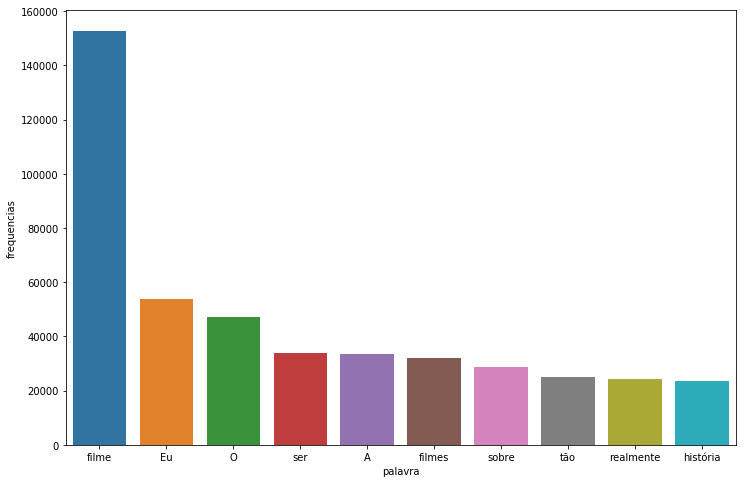

In [22]:
pareto(dataframe, "tratamento_1", 10)

#Da pra ver que nao tem mais aquele "-" nas frequencias.

#2 Retirar a acentuação das features

Convenhamos, pontuar corretamente não é algo comum em textos informais online. Logo não e interessante que o LogisticRegression faça distinção entre a palavra "ótimo" e "otimo". Vamos retirar a acentuação de nosssas features usando o unidecode.

In [27]:
!pip install unidecode

In [0]:

import unidecode

#Estou aplicando o unicode para cada feature no dataframe, seguindo a coluna do tratamento anterior.
#Estou gostando mesmo dessa sintaxe de python.
tratamento_2 = [unidecode.unidecode(feature) for feature in dataframe["tratamento_1"]]

#Vou retirar a acentuacao das stop words e rodar de novo para essa coluna, just in case.
punct_sp_sem_acento = [unidecode.unidecode(sw) for sw in pontuacoes_stopwords ]

frases_processadas = list()#Aqui ficaram nossas features tratadas
tokenizador = tokenize.WordPunctTokenizer()

#Para cada feature da coluna tratamento_2.
for feature in tratamento_2:
  #Aqui ficaram os tokens de nossa palavras, sem os tokens de pontuacoes.
  nova_frase = list() 
  #dividindo a feature em tokens.
  palavra_texto = tokenizador.tokenize(feature)
 
  #Agora vamos iterar na lista de tokens para tirar as stop words sem acento.
  #Para cada item na lista palavra_texto, os tokens.
  for palavra in palavra_texto:
    #Se a palavra nao estiver na lista de punct_sp_sem_acento, 
    #entao posso adicionar na lista nova_frase.
      if(palavra not in punct_sp_sem_acento):
          nova_frase.append(palavra)
  #Vou juntar a lista nova_frase em uma string com o join(), separando por espaco,
  #e adicionar na lista de frases processadas.
  frases_processadas.append( ' '.join(nova_frase) )
  
  
dataframe["tratamento_2"]= frases_processadas


In [29]:
dataframe.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_0,tratamento_1,tratamento_2
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes acao mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever musicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,Filmes fotos latao palavra apropriada verdade ...


In [31]:
#Vamos comparar agora a acuracia anterior e a de agora.

classificar_texto(dataframe, "tratamento_1", "classificacao")
classificar_texto(dataframe, "tratamento_2", "classificacao")

#Tivemos um ganho de 1%.

0.6781237363526081
0.6887181560857258


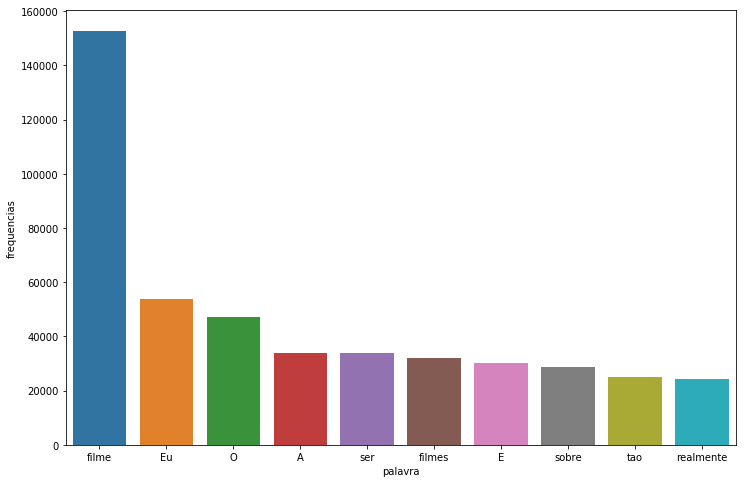

In [32]:
#Vamos ver o pareto agora

pareto(dataframe, "tratamento_2", 10)

#3 Colocando as features em lowercase

Não queremos que o LogisticRegression interptre um "Bom" diferente de um "bom". Vamos jogar todas nossas features para lowercase, usando a função lower() da classe String.

In [0]:
tratamento_3 = (feature.lower() for feature in dataframe.tratamento_2)

#Feito isso, podem existir stop_words que antes nao foram eliminadas antes
#pois estavam em maiusculo. Por isso, vamos processar de novo.

frases_processadas = list()#Aqui ficaram nossas features tratadas
tokenizador = tokenize.WordPunctTokenizer()

#Para cada feature da coluna tratamento_3.
for feature in tratamento_3:
  #Aqui ficaram os tokens de nossa palavras, sem os tokens de pontuacoes.
  nova_frase = list() 
  #dividindo a feature em tokens.
  palavra_texto = tokenizador.tokenize(feature)
 
  #Agora vamos iterar na lista de tokens para tirar as stop words.
  #Para cada item na lista palavra_texto, os tokens.
  for palavra in palavra_texto:
    #Se a palavra nao estiver na lista de punct_sp_sem_acento, 
    #entao posso adicionar na lista nova_frase.
      if(palavra not in punct_sp_sem_acento):
          nova_frase.append(palavra)
  #Vou juntar a lista nova_frase em uma string com o join(), separando por espaco,
  #e adicionar na lista de frases processadas.
  frases_processadas.append( ' '.join(nova_frase) )
  
  
dataframe["tratamento_3"]= frases_processadas

In [34]:
dataframe.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_0,tratamento_1,tratamento_2,tratamento_3
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,Mais vez Sr Costner arrumou filme tempo necess...,vez sr costner arrumou filme tempo necessario ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes acao mesmos...,exemplo motivo maioria filmes acao mesmos gene...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,Primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever musicas todos gos...,beatles puderam escrever musicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,Filmes fotos latao palavra apropriada verdade ...,filmes fotos latao palavra apropriada verdade ...


In [35]:
#Comparando a acuracia anterior com a de agora.

classificar_texto(dataframe, "tratamento_2", "classificacao")
classificar_texto(dataframe, "tratamento_3", "classificacao")

#Mais um ganho de 1%

0.6840274969672463
0.6987464617873028


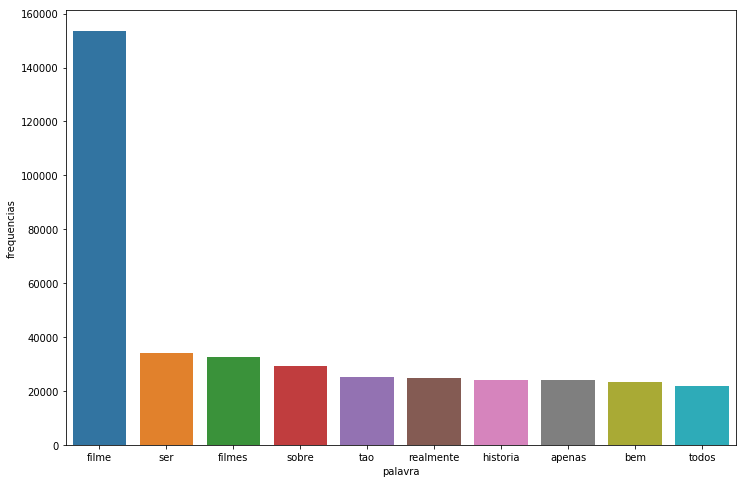

In [36]:
#Novo grafico pareto

pareto(dataframe, "tratamento_3", 10)